# Arctic Rivers exploratory data analysis

This notebook is for exploring data from the Arctic Rivers Project, sponsored by NSF NNA. The goal is to see what we are working with here, asking questions that are relevant to how this data could be integrated into NCR or similar.

Context: co-developed with Indigenous partners a model chain that involves dynamic downscaling (4 km) of a calibrated RASM/WRF/CSM configuration for a historical 30 yr period, and two mid-century simulations using the delta-method, and four downscaled CESM2 LE members each for historical and mid-century 30-yr periods. Simulations have been routed to estimate streamflow and (calibrated) river temperatures (paper in press) for AK and YK rivers. 

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

# path to data is /beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/
data_dir = Path("/beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/")

## Data package

Looks like all files are netCDFs:

In [2]:
fps = list(data_dir.glob("*"))
assert all(fp == fp2 for fp, fp2 in zip(fps, data_dir.glob("*.nc")))
print(f"Number of files: {len(fps)}")

Number of files: 1056


And all files have a 3 part name structure:

In [17]:
assert all([len(fp.name.split("_")) == 3 for fp in fps])
print("Some random files:")

print(fps[0].name)
print(fps[200].name)
print(fps[999].name)

Some random files:
2056_fC2LE2_climate.nc
2019_hC2LE9_WT.nc
2009_historical_climate.nc


Looks like we have `<year>_<model>_<variables>.nc` , with the following possible values:

In [58]:
years, models_, variables_ = zip(*[fp.name.split(".")[0].split("_") for fp in fps])
models = list(set(models_))
variables = list(set(variables_))
print(f"year -- first year: {min(years)}, last year: {max(years)}")
print(f"models: {sorted(set(models))}")
print(f"scenarios: {set(variables)}")

year -- first year: 1990, last year: 2065
models: ['fC2LE2', 'fC2LE4', 'fC2LE7', 'fC2LE9', 'fPGWh', 'fPGWm', 'hC2LE2', 'hC2LE4', 'hC2LE7', 'hC2LE9', 'historical']
scenarios: {'WT', 'Q', 'climate'}


Let's get an idea of sizes:

In [47]:
rows = []
for model in models:
    for var in variables:
        modvar_sizes = []
        for year in range(1990, 2066):
            fp = data_dir.joinpath(f"{year}_{model}_{var}.nc")
            if not fp.exists():
                continue
            else:
                size = fp.stat().st_size / 1e6
                modvar_sizes.append(size)

        rows.append(
            {
                "model": model,
                "var": var,
                "mean_size": f"{np.mean(modvar_sizes).astype(int)} MB",
                "std_size": f"{np.std(modvar_sizes).astype(int)} MB",
            }
        )

df = pd.DataFrame(rows)

Mean sizes for each:

In [48]:
df.pivot(index="var", columns="model", values="mean_size")

model,fC2LE2,fC2LE4,fC2LE7,fC2LE9,fPGWh,fPGWm,hC2LE2,hC2LE4,hC2LE7,hC2LE9,historical
var,,,,,,,,,,,
Q,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,50 MB,52 MB
WT,594 MB,594 MB,594 MB,594 MB,595 MB,595 MB,594 MB,594 MB,594 MB,594 MB,595 MB
climate,969 MB,969 MB,971 MB,971 MB,966 MB,969 MB,986 MB,990 MB,987 MB,988 MB,981 MB


Standard deviations:

In [49]:
df.pivot(index="var", columns="model", values="std_size")

model,fC2LE2,fC2LE4,fC2LE7,fC2LE9,fPGWh,fPGWm,hC2LE2,hC2LE4,hC2LE7,hC2LE9,historical
var,,,,,,,,,,,
Q,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB,2 MB
WT,28 MB,28 MB,28 MB,28 MB,26 MB,26 MB,28 MB,28 MB,28 MB,28 MB,26 MB
climate,46 MB,50 MB,46 MB,48 MB,46 MB,45 MB,47 MB,47 MB,47 MB,48 MB,45 MB


What about represnetation of models / vairable groups in the dataset?

In [63]:
unique_models, counts = np.unique(models_, return_counts=True)
pd.DataFrame({"Model": models, "File count": counts})

,Model,File count
0,hC2LE4,96
1,hC2LE7,96
2,hC2LE9,96
3,fC2LE7,96
4,fC2LE4,96
5,hC2LE2,96
6,fPGWh,96
7,historical,96
8,fC2LE9,96
9,fPGWm,96


In [66]:
unique_groups, counts = np.unique(variables_, return_counts=True)
pd.DataFrame({"Variable group": unique_groups, "File count": counts})

,Variable group,File count
0,Q,352
1,WT,352
2,climate,352


## File structure

From above, it looks like most files are of similar sizes within variable group and across models. So let's have a look at a file from each variable group. 

In [10]:
tmp_fps = sorted([fp for fp in fps if "fPGWh" in fp.name])[:3]
for fp in tmp_fps:
    print("File", fp)
    print(xr.open_dataset(fp), end="\n\n---------------------------------\n\n")

File /beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/2034_fPGWh_Q.nc
<xarray.Dataset> Size: 50MB
Dimensions:          (time: 365, seg: 34346)
Coordinates:
  * time             (time) datetime64[ns] 3kB 2034-01-01T12:00:00 ... 2034-1...
  * seg              (seg) int64 275kB 81009065 81010344 ... 81019848 81019993
Data variables:
    IRFroutedRunoff  (time, seg) float32 50MB ...
Attributes:
    version:  v1.2.1

---------------------------------

File /beegfs/CMIP6/arctic-cmip6/Arctic_Rivers_Data/2034_fPGWh_WT.nc
<xarray.Dataset> Size: 600MB
Dimensions:      (time: 365, no_seg: 2, hru: 34208)
Coordinates:
  * time         (time) datetime64[ns] 3kB 2034-01-01 2034-01-02 ... 2034-12-31
  * no_seg       (no_seg) int32 8B 1 2
  * hru          (hru) float64 274kB 8.1e+07 8.1e+07 8.1e+07 ... 8.1e+07 8.1e+07
Data variables:
    T_stream     (time, no_seg, hru) float64 200MB ...
    T_air        (time, no_seg, hru) float64 200MB ...
    T_headwater  (time, no_seg, hru) float64 200MB ...

--------

So it looks like `_climate.nc` files have the forcing climate data used:

In [14]:
ds = xr.open_dataset(data_dir.joinpath("2034_fPGWh_climate.nc"))
ds

<xarray.Dataset> Size: 4GB
Dimensions:        (time: 365, hist_interval: 2, lon: 782, lat: 662)
Coordinates:
  * time           (time) datetime64[ns] 3kB 2034-01-02 ... 2035-01-01
  * lon            (lon) float32 3kB 184.2 184.3 184.3 ... 225.7 225.7 225.8
  * lat            (lat) float32 3kB 50.01 50.04 50.07 ... 69.83 69.86 69.89
Dimensions without coordinates: hist_interval
Data variables:
    time_bounds    (time, hist_interval) datetime64[ns] 6kB ...
    H2OSNO         (time, lat, lon) float32 756MB ...
    QFLX_EVAP_TOT  (time, lat, lon) float32 756MB ...
    RAIN           (time, lat, lon) float32 756MB ...
    SNOW           (time, lat, lon) float32 756MB ...
    TSA            (time, lat, lon) float32 756MB ...
Attributes: (12/39)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   Sat May 18 12:36:10 2024: ncrc...
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          day_1
    NCO:                                       netCDF Operators version 5.1.9...

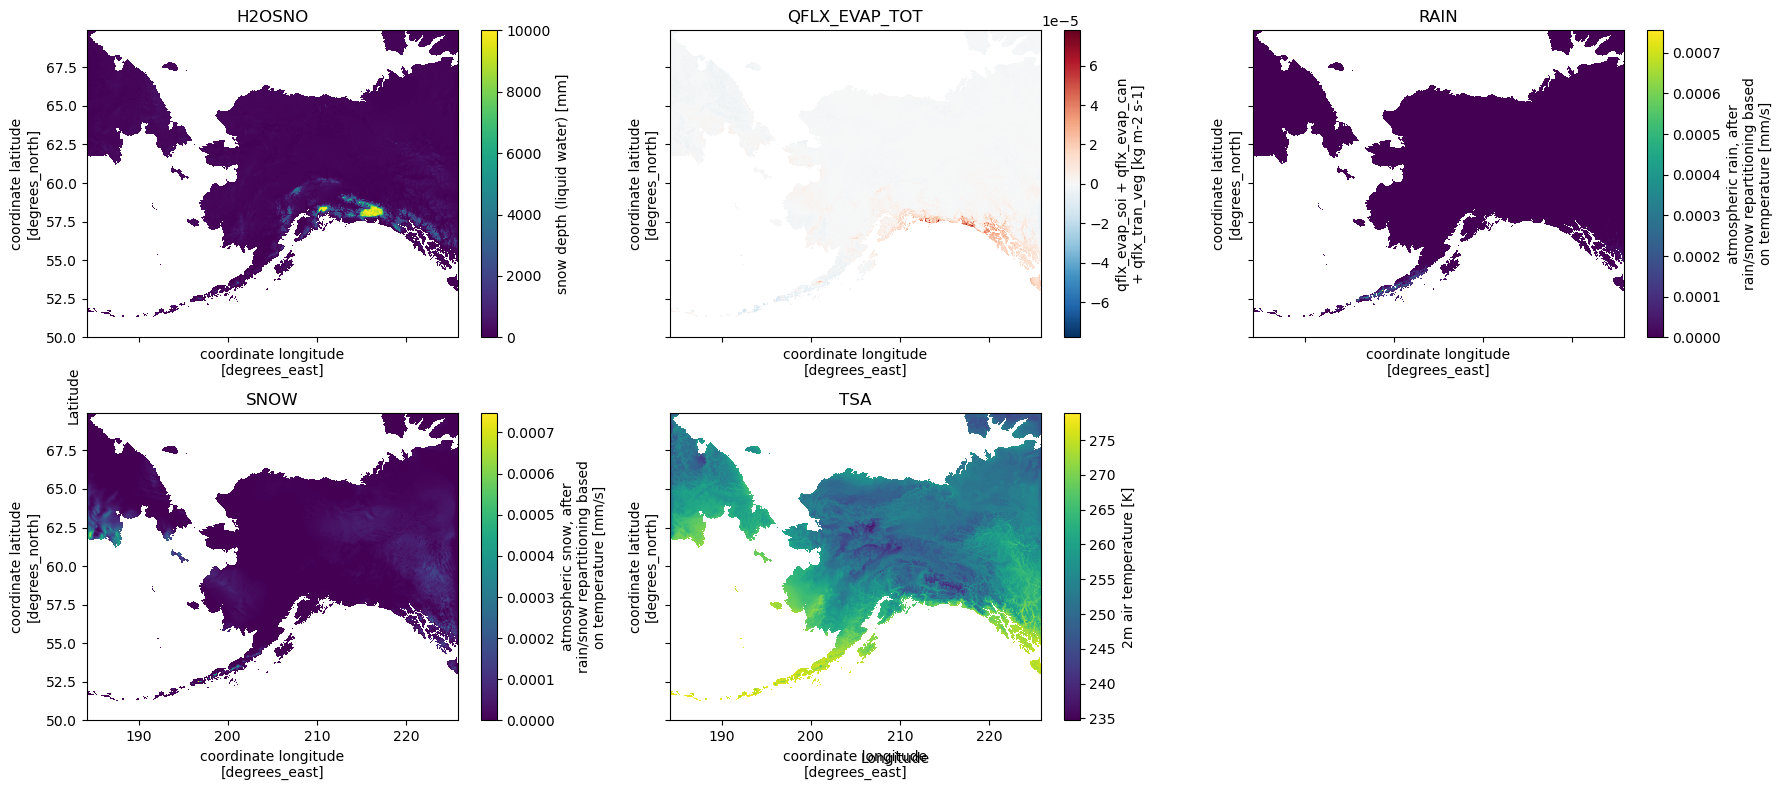

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)

# Plot each variable in the same plot
for var, ax in zip(["H2OSNO", "QFLX_EVAP_TOT", "RAIN", "SNOW", "TSA"], axes.flatten()):
    ds.isel(time=0)[var].plot(ax=ax, label=var)
    ax.set_title(var)

# Remove the last subplot
fig.delaxes(axes.flatten()[-1])

plt.tight_layout()
plt.show()

Then we have the Runoff data, indexed by segment:

In [3]:
q_ds = xr.open_dataset(data_dir.joinpath("2034_fPGWh_Q.nc"))
q_ds

<xarray.Dataset> Size: 50MB
Dimensions:          (time: 365, seg: 34346)
Coordinates:
  * time             (time) datetime64[ns] 3kB 2034-01-01T12:00:00 ... 2034-1...
  * seg              (seg) int64 275kB 81009065 81010344 ... 81019848 81019993
Data variables:
    IRFroutedRunoff  (time, seg) float32 50MB ...
Attributes:
    version:  v1.2.1

In [4]:
wt_ds = xr.open_dataset(data_dir.joinpath("2034_fPGWh_WT.nc"))
wt_ds

<xarray.Dataset> Size: 600MB
Dimensions:      (time: 365, no_seg: 2, hru: 34208)
Coordinates:
  * time         (time) datetime64[ns] 3kB 2034-01-01 2034-01-02 ... 2034-12-31
  * no_seg       (no_seg) int32 8B 1 2
  * hru          (hru) float64 274kB 8.1e+07 8.1e+07 8.1e+07 ... 8.1e+07 8.1e+07
Data variables:
    T_stream     (time, no_seg, hru) float64 200MB ...
    T_air        (time, no_seg, hru) float64 200MB ...
    T_headwater  (time, no_seg, hru) float64 200MB ...

Strangely enough, the `seg` variable in the `Q` dataset and the `hru` variable in the `WT` dataset have many values in common, with all of the `hru` values being contained in the `seg` variable:

In [5]:
np.all([x in q_ds.seg for x in wt_ds.hru.values.astype(int)])

True

These definitely look like HUC8 codes: 

In [6]:
wt_ds.hru

<xarray.DataArray 'hru' (hru: 34208)> Size: 274kB
array([81001023., 81001025., 81001027., ..., 81000060., 81000063., 81000068.])
Coordinates:
  * hru      (hru) float64 274kB 8.1e+07 8.1e+07 8.1e+07 ... 8.1e+07 8.1e+07

Unfortunately, there does not appear to be a way of making this dataset spatial without some external data.

We can still do some plotting, however. 

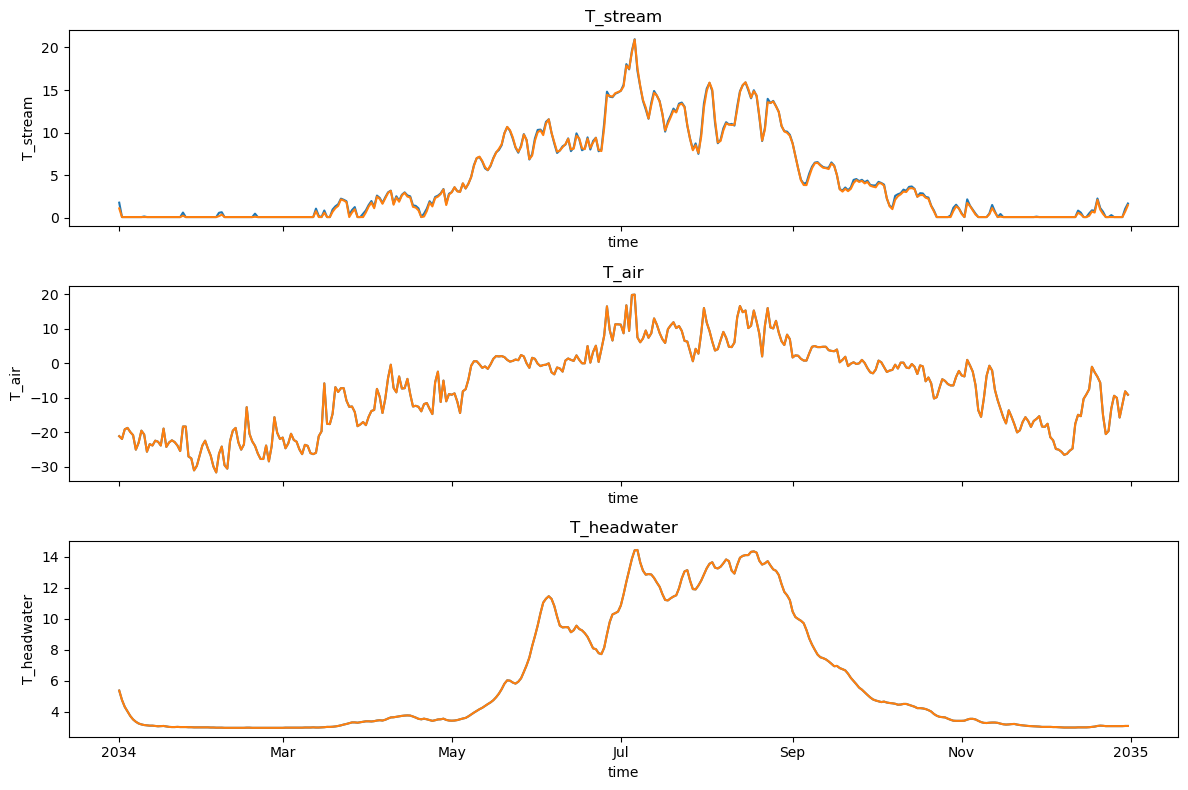

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for ax, var in zip(axes, ["T_stream", "T_air", "T_headwater"]):
    wt_ds[var].isel(hru=0, no_seg=0).plot(ax=ax)
    wt_ds[var].isel(hru=0, no_seg=1).plot(ax=ax)
    ax.set_title(var)

plt.tight_layout()
plt.show()

It looks like the differences between `no_seg` values are pretty small for the `T_stream` variable.

And there are none between them for the other two variables!

In [11]:
assert np.all(
    (wt_ds["T_air"].isel(no_seg=0).values - wt_ds["T_air"].isel(no_seg=1).values) == 0
)
assert np.all(
    (
        wt_ds["T_headwater"].isel(no_seg=0).values
        - wt_ds["T_headwater"].isel(no_seg=1).values
    )
    == 0
)

True